In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from warnings import filterwarnings
filterwarnings("ignore")

# Data Loading and Understanding

In [ ]:
path_data = "/content/car.data"                   #The data has been downloaded from https://archive.ics.uci.edu/ml/datasets/Car+Evaluation
columns = ["Buying", "Maint", "Doors", "Persons", "Lug_boot", "Safety", "Car"]

data_car = pd.read_csv(path_data, names = columns)
data_car.head()

,Buying,Maint,Doors,Persons,Lug_boot,Safety,Car
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


The Car Evaluation Database contains examples with the structural information removed, i.e., directly relates CAR to the six input attributes: Buying, Maint, Doors, Persons, Lug_boot, Safety. Details are explained below

1. CAR : car acceptability (unacc, acc, good, v-good)

2. PRICE    : overall price
   * Buying    : buying price (v-high, high, med, low)
   * Maint     : price of the maintenance (v-high, high, med, low)

3. TECH     : technical characteristics
   * COMFORT   : comfort
   ** Doors    : number of doors (2, 3, 4, 5-more)
   ** Persons  : capacity in terms of persons to carry (2, 4, more)
   ** Lug_boot : the size of luggage boot (small, med, big)
   * SAFETY    : estimated safety of the car (low, med, high)

In [ ]:
data_car.shape

(1728, 7)

Number of Instances: 1728
   (instances completely cover the attribute space)

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_indices, test_indices in sss.split(data_car, data_car["Buying"]):
  train_data = data_car.iloc[train_indices]
  test_data = data_car.iloc[test_indices]


print("train_data.shape: ", train_data.shape)
print("test_data.shape: ", test_data.shape)

train_data.shape:  (1382, 7)
test_data.shape:  (346, 7)


We have split the dataset into a train dataset and a test dataset based on "Buying" feature.
>
DNN Model will be trained on train dataset and its performance will be measured on test dataset.
>
The test dataset won't be touched till prediction

In [ ]:
train_data.describe().T

,count,unique,top,freq
Buying,1382,4,low,346
Maint,1382,4,low,358
Doors,1382,4,4,351
Persons,1382,3,2,468
Lug_boot,1382,3,med,462
Safety,1382,3,high,465
Car,1382,4,unacc,969


All the features have categorical observations. We can see statistic distributions of the features in train dataset above like observation count, unique values, most used observations and it's frequency.

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1382 entries, 1478 to 961
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Buying    1382 non-null   object
 1   Maint     1382 non-null   object
 2   Doors     1382 non-null   object
 3   Persons   1382 non-null   object
 4   Lug_boot  1382 non-null   object
 5   Safety    1382 non-null   object
 6   Car       1382 non-null   object
dtypes: object(7)
memory usage: 86.4+ KB


Train dataset has no any missing value

# Preparing the Data for Model

All the features in the dataset have categorical observations. We should do one-hot encoding. By doing so, the observations will be only either 0 or 1 (0 if No, 1 if Yes) according to columns created from the categorical observations.

In [ ]:
def dummies(data, columns):

  data = pd.get_dummies(data, columns=columns)
  return data

train_data = dummies(train_data, train_data.drop("Car", axis=1).columns)
train_data.head()

,Car,Buying_high,Buying_low,Buying_med,Buying_vhigh,Maint_high,Maint_low,Maint_med,Maint_vhigh,Doors_2,...,Doors_5more,Persons_2,Persons_4,Persons_more,Lug_boot_big,Lug_boot_med,Lug_boot_small,Safety_high,Safety_low,Safety_med
1478,acc,0,1,0,0,1,0,0,0,0,...,0,0,0,1,0,0,1,1,0,0
199,unacc,0,0,0,1,1,0,0,0,0,...,1,0,1,0,0,0,1,0,0,1
1532,unacc,0,1,0,0,0,0,1,0,1,...,0,0,0,1,0,0,1,1,0,0
1141,unacc,0,0,1,0,0,0,1,0,0,...,0,1,0,0,1,0,0,0,0,1
1123,acc,0,0,1,0,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,1


Now, the dataset has 22 columns.

In [ ]:
def transforming_data(data):
  data["Car"] = [0 if i == "unacc" else 1 if i == "acc" else 2 if i == "good" else 3 for i in data.Car]
  return data
train_data = transforming_data(train_data)

The observations of the target variable, "Car", have been transformed to numeric values so that DNN Model works and predicts. We have assigned those numbers below to the categorical observations;
>
* 0 if "unacc",
* 1 if "acc",
* 2 if "good",
* 3 if "vgood".

In [ ]:
X = train_data.drop(["Car"], axis=1).values
y = train_data[["Car"]].values

The train dataset has been split into X data and y data.
* X data is consisted of independent variables which DNN model take as input,
* y data is the dependent variable which DNN Model will predict.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X,y,
                                                  test_size=0.2,
                                                  random_state=42)

X data has been split into X_train which DNN Model will be trained, and X_val which the Model's performance will be validated.
>
Similarly y data has been split into y_train and y_val.

# Building DNN Model

Let's firstly start by importing some necessary libraries

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, BatchNormalization, Dropout, Activation, InputLayer
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils.np_utils import to_categorical

In [ ]:
#Some parameters we will use later

input_shape = X_train.shape[1]
epochs = 500
batch_size = 32
nb_class = len(np.unique(y_train))

1. input_shape, which is the number of columns of X_train, will be used in the DNN Model as input,
2. training iteration will be 500 times,
3. 32 samples in every iteration will be used,
4. number of class will be used in the DNN Model as output.

In [ ]:
y_train = to_categorical(y_train, nb_class)
y_val = to_categorical(y_val, nb_class)

One-hot encoding has been implemented to y_train and y_val.

In [ ]:
def building_model(input_shape, nb_classes):

  model = Sequential()
  model.add(InputLayer(input_shape=[input_shape]))

  model.add(Flatten())

  model.add(Dense(units=128, kernel_initializer="normal"))
  model.add(BatchNormalization())
  model.add(Activation("relu"))
  model.add(Dropout(0.5))

  model.add(Dense(units=64, kernel_initializer="normal"))
  model.add(BatchNormalization())
  model.add(Activation("relu"))
  model.add(Dropout(0.5))

  model.add(Dense(units=32, kernel_initializer="normal"))
  model.add(BatchNormalization())
  model.add(Activation("relu"))
  model.add(Dropout(0.5))

  model.add(Dense(units=nb_class, activation="softmax"))

  model.compile(loss="categorical_crossentropy", optimizer="sgd", metrics=["accuracy"])

  return model

  
model = building_model(input_shape, nb_class)

Finally we have built a DNN Model by calling building_model function.
>
The Model;
* Takes input_shape variable as input,
* Uses "normal" as kernel_initializer, BatchNormalization to normalize, "relu" as activation and randomly deactive %50 of neuron networks in all dense layers, except output,
* Gives neurons in the amount of number of class and uses "softmax" as activation in output layer.
>
Also, the model has been compiled with parameters below:
* "categorical_crossentropy" as loss,
* "sgd" as optimizer,
* "accuracy" as evaluation metrics.

# Train the Model

It is now time to train the Model and validate its performance. We will use EarlyStoping which will stop model training if no more improvement in validation loss after every 20 epoch.

In [ ]:
early_stopping = EarlyStopping(patience=20,
                               restore_best_weights=True,
                               monitor="val_loss")
hist = model.fit(X_train, y_train, batch_size=batch_size,
          epochs=epochs,
          validation_data=[X_val, y_val],
          callbacks=[early_stopping])

Epoch 1/500
35/35 [==============================] - 3s 21ms/step - loss: 1.7670 - accuracy: 0.2326 - val_loss: 1.2378 - val_accuracy: 0.7256
Epoch 2/500
35/35 [==============================] - 0s 7ms/step - loss: 1.0981 - accuracy: 0.5258 - val_loss: 1.1233 - val_accuracy: 0.7256
Epoch 3/500
35/35 [==============================] - 0s 7ms/step - loss: 0.9034 - accuracy: 0.6579 - val_loss: 1.0232 - val_accuracy: 0.7256
Epoch 4/500
35/35 [==============================] - 0s 5ms/step - loss: 0.7636 - accuracy: 0.7186 - val_loss: 0.9292 - val_accuracy: 0.7256
Epoch 5/500
35/35 [==============================] - 1s 16ms/step - loss: 0.7043 - accuracy: 0.7557 - val_loss: 0.8409 - val_accuracy: 0.7256
Epoch 6/500
35/35 [==============================] - 0s 6ms/step - loss: 0.6663 - accuracy: 0.7475 - val_loss: 0.7595 - val_accuracy: 0.7834
Epoch 7/500
35/35 [==============================] - 0s 7ms/step - loss: 0.5933 - accuracy: 0.7855 - val_loss: 0.7018 - val_accuracy: 0.8231
Epoch 8/500

We had specified 500 epochs but model's training stopped in 257th epoch because of no more improvement on val_loss.
>
According to the results of the training, the model has no overfitting and underfitting problem. The validation score in the last epoch is %94.58 while training accuracy is %93.39. That's a good result. 
>
A figure below visualizes the results of each epoch


>
Let see clearer on a figure.

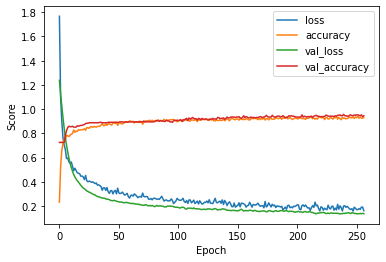

In [ ]:
pd.DataFrame(hist.history).plot()
plt.xlabel("Epoch")
plt.ylabel("Score");

# Time to Touch Test Dataset

Lets now evaluate the model on the test dataset.

In [ ]:
test_data = dummies(test_data, test_data.drop("Car", axis=1).columns)
test_data = transforming_data(test_data)
X_test = test_data.drop(["Car"], axis=1).values
y_test = test_data[["Car"]].values
y_test = to_categorical(y_test, nb_class)

Before evaluating the model and predict, we have made some preprocessing on the test dataset like we did for the train dataset. 

In [ ]:
loss, acc = model.evaluate(X_test, y_test, batch_size)

print("Loss:", loss)
print("Accuracy:", acc)

11/11 [==============================] - 0s 2ms/step - loss: 0.0901 - accuracy: 0.9566
Loss: 0.09013073891401291
Accuracy: 0.9566473960876465


The result is good. Lets predict first 10 datas in X_test.

In [ ]:
class_labels = ["unacc", "acc", "good", "vgood"]

In [ ]:
pred_prob = model.predict(X_test[:10])

pred_class = np.argmax(pred_prob, axis=1)

for i in range(10):
  print(f"Estimated class is {pred_class[i]} and it's label is", class_labels[pred_class[i]])

Estimated class is 0 and it's label is unacc
Estimated class is 1 and it's label is acc
Estimated class is 0 and it's label is unacc
Estimated class is 0 and it's label is unacc
Estimated class is 0 and it's label is unacc
Estimated class is 0 and it's label is unacc
Estimated class is 0 and it's label is unacc
Estimated class is 0 and it's label is unacc
Estimated class is 3 and it's label is vgood
Estimated class is 0 and it's label is unacc


The model has predicted classes of the first 10 data. We have printed the class results and their labels by using a for loop. Lets compare the result with original results.

In [ ]:
y_test[:10]

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.]], dtype=float32)

The model has correctly predicted all.

Finally, lets save the model and finish the process

In [ ]:
model.save("DNN_For_Car_Evaluation.h5")